In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import os
import sys
from pathlib import Path

workding_dir = "/content/drive/MyDrive/logical-reasoning/"
os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: /content/drive/MyDrive/logical-reasoning/


In [24]:
need_to_setup_env = False
need_to_setup_env

False

In [25]:
if need_to_setup_env:
    %pip install -r requirements.txt
    %cd /content/
    %rm -rf LLaMA-Factory
    !git clone https://github.com/hiyouga/LLaMA-Factory.git
    %cd LLaMA-Factory
    %ls
    %pip install -e .[torch,bitsandbytes]

In [26]:
os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: /content/drive/MyDrive/logical-reasoning/


In [27]:
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

loading env vars from: /content/drive/MyDrive/logical-reasoning/.env


True

In [28]:
import os

model_name = os.getenv("MODEL_NAME")
adapter_name_or_path = os.getenv("ADAPTER_NAME_OR_PATH")
load_in_4bit = os.getenv("LOAD_IN_4BIT") == "true"
data_path = os.getenv("LOGICAL_REASONING_DATA_PATH")
results_path = os.getenv("LOGICAL_REASONING_RESULTS_PATH")
use_english_datasets = os.getenv("USE_ENGLISH_DATASETS") == "true"

print(model_name, adapter_name_or_path, load_in_4bit, data_path, results_path, use_english_datasets)

internlm/internlm2_5-7b-chat-1m None True datasets/mgtv results/mgtv-results_colab_p2.csv False


In [29]:
!nvidia-smi

Thu Jul 11 15:27:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   39C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [30]:
%%time
!python --version
!pip show flash-attn

Python 3.10.12
CPU times: user 10.1 ms, sys: 1.94 ms, total: 12 ms
Wall time: 610 ms


In [31]:
from llm_toolkit.logical_reasoning_utils import *

In [32]:
df_alpaca = load_alpaca_data(data_path, using_p1=False)
df_alpaca.head()

loading existing data from: llama-factory/data/alpaca_mgtv_p2.json


instruction input output
0  你是一个情景猜谜游戏的主持人。游戏规则如下：\n\n1. 参与者会得到一个谜面，谜面会描述一...           不是
1  你是一个情景猜谜游戏的主持人。游戏规则如下：\n\n1. 参与者会得到一个谜面，谜面会描述一...           不是
2  你是一个情景猜谜游戏的主持人。游戏规则如下：\n\n1. 参与者会得到一个谜面，谜面会描述一...          不重要
3  你是一个情景猜谜游戏的主持人。游戏规则如下：\n\n1. 参与者会得到一个谜面，谜面会描述一...           不是
4  你是一个情景猜谜游戏的主持人。游戏规则如下：\n\n1. 参与者会得到一个谜面，谜面会描述一...            是

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 31572 (\N{CJK UNIFIED IDEOGRAPH-7B

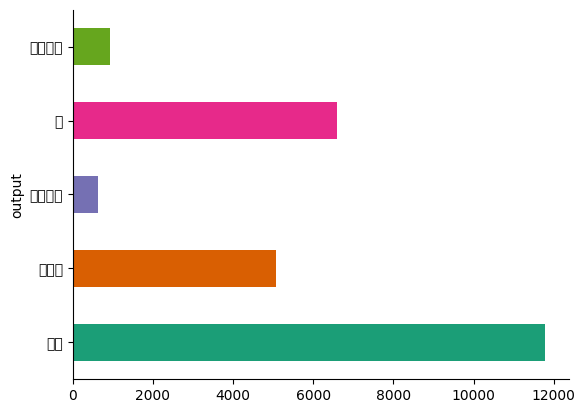

In [33]:
# @title output

from matplotlib import pyplot as plt
import seaborn as sns
df_alpaca.groupby('output').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
%%time

!sh ./scripts/tune-lf.sh config/internlm2_5_7b_lora_sft_bf16_p2.yaml

Current Directory:
/content/drive/MyDrive/logical-reasoning/llama-factory
config/internlm2_5_7b_lora_sft_bf16_p2.yaml:
 {
  "model_name_or_path": "internlm/internlm2_5-7b-chat-1m",
  "stage": "sft",
  "do_train": true,
  "finetuning_type": "lora",
  "lora_target": "all",
  "loraplus_lr_ratio": 16.0,
  "upcast_layernorm": true,
  "dataset": "alpaca_mgtv_p2",
  "template": "chatml",
  "cutoff_len": 1024,
  "max_samples": 5000,
  "overwrite_cache": true,
  "preprocessing_num_workers": 16,
  "output_dir": "saves/internlm2_5_7b/lora/sft_bf16_p2",
  "logging_steps": 100,
  "save_steps": 562,
  "plot_loss": true,
  "overwrite_output_dir": true,
  "per_device_train_batch_size": 1,
  "gradient_accumulation_steps": 8,
  "learning_rate": 0.0001,
  "num_train_epochs": 4.0,
  "lr_scheduler_type": "cosine",
  "warmup_ratio": 0.1,
  "bf16": true,
  "ddp_timeout": 180000000,
  "val_size": 0.1,
  "per_device_eval_batch_size": 1,
  "eval_strategy": "steps",
  "eval_steps": 562,
  "report_to": "wandb",
 

In [ ]:
def evaluate_model_all_epochs(model_name, adapter_path_base, num_train_epochs, start_epoch=0, load_in_4bit=True, num_of_entries=-1):
    os.environ["MODEL_NAME"] = model_name
    os.environ["LOAD_IN_4BIT"] = "true" if load_in_4bit else "false"
    for i in range(start_epoch, num_train_epochs + 1):
        print(f"Epoch {i}")
        if i == 0:
            os.unsetenv("ADAPTER_NAME_OR_PATH")
        else:
            adapter_path = f"{adapter_path_base}/checkpoint-{562 * i}"
            os.environ["ADAPTER_NAME_OR_PATH"] = adapter_path

        !python llm_toolkit/eval_logical_reasoning.py {num_of_entries}

In [ ]:
%%time

evaluate_model_all_epochs("internlm/internlm2_5-7b-chat-1m", "llama-factory/saves/internlm2_5_7b/lora/sft_bf16_p2", 4, start_epoch=0, load_in_4bit=False, num_of_entries=-1)